In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mshr
import numpy as np
import scipy.integrate as integrate
from fenics import *
import pickle

# local imports
from modules.mesh_utils import get_mesh
from modules.physics_utils import get_VandE, compute_trajectory, coord_impact, intersection
#from modules.plotting_utils import ?

# What about $\rho_{elec} \ne 0$ ?

In [27]:
mesh_dict = { # we need L_mot-L_1 < 2*l_mot !
    'L_mot' : .005,
    'l_mot' : .003,
    'L_1' : .003, # dim_trou = L_mot-L = .002 ici
    'l_1': .001,
    'L_2' : .004, # dim_trou = .001 ici
    'l_2' : .002,
    'delta_vert_12' : .001,
    'L_vacuum' : .05,
    'l_vacuum': .02,
    'mesh_resolution' : 300,
    'refine_mesh' : True,
}

phi_dict = {
    'Phi_top_mot' : 0,
    'Phi_bord_mot': 'N',
    'Phi_electrode1' :30,
    'Phi_inter_electrode':'N',
    'Phi_electrode2':300,
    'Phi_sup_vacuum':'N',
    'Phi_inf_vacuum':'N',
}

physics_consts_dict = {
    'rhoelec': 1e20*1.6e-19,
    'l_rho':0.005,
    'PERMITTIVITY' : 8.54e-12,
    'CHARGE':1.6e-19,
    'M_NUCLEON':1.7e-27,
}

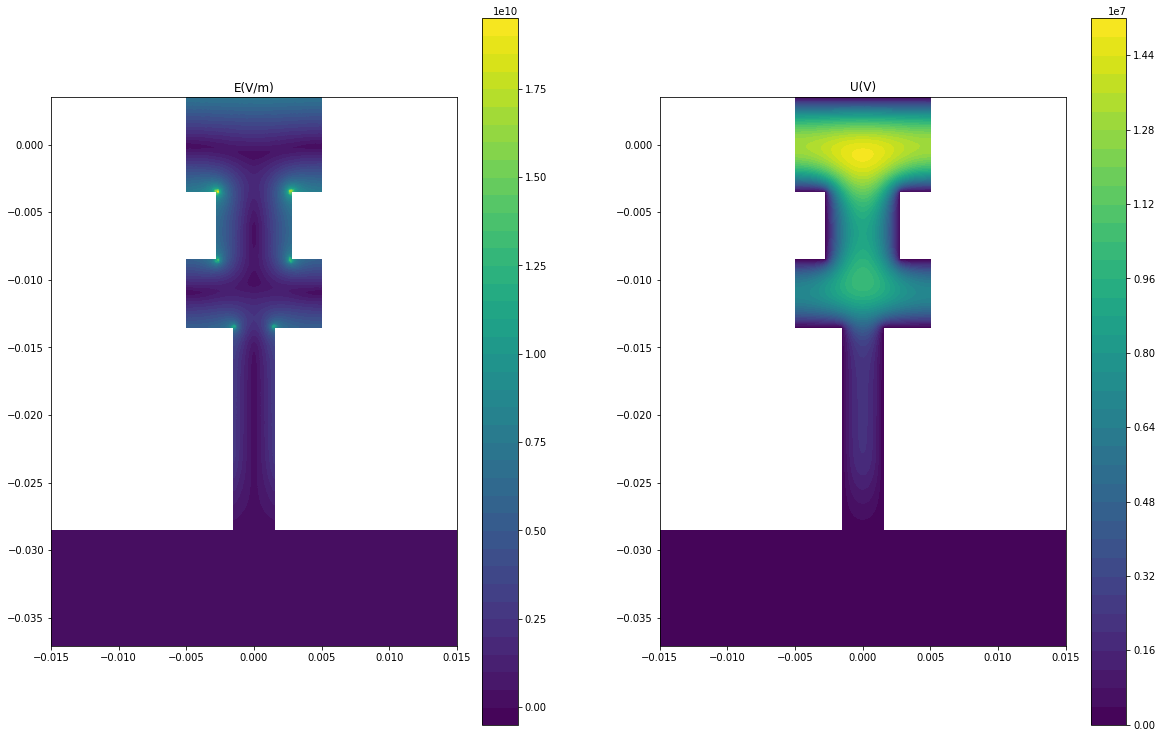

resolution=300, rho=1e18*e


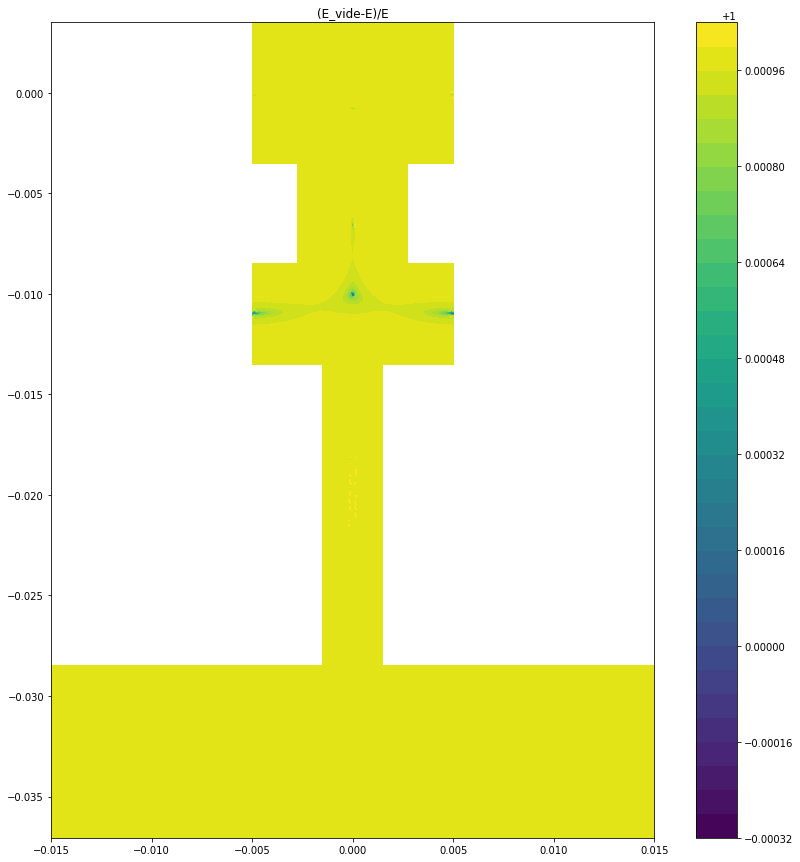

In [28]:
borne_inf_x=-1.5*mesh_dict['L_mot']
borne_sup_x=1.5*mesh_dict['L_mot']
borne_inf_y=-1.3*(.5*mesh_dict['l_mot']+mesh_dict['l_1']+mesh_dict['l_2']+mesh_dict['delta_vert_12'])
borne_sup_y=.5*mesh_dict['l_mot']

Phi1, E1, f1 = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
NE1=sqrt(dot(E1,E1))

plt.figure(figsize=(20,13))
plt.subplot(1,2,1)
fig=plot(NE1)
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.subplot(1,2,2)
fig=plot(Phi1)
plt.title('U(V)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.show()
print('resolution=300, rho=1e18*e')

physics_consts_dict['rhoelec']=0

Phi2, E2, f2 = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
NE2=sqrt(dot(E2,E2))

plt.figure(figsize=(15,15))
fig=plot(np.abs(NE2-NE1)/NE1+1e-3)
plt.title('(E_vide-E)/E')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.show()



# let's change rho

In [ ]:
mesh_dict = { # we need L_mot-L_1 < 2*l_mot !
    'L_mot' : .005,
    'l_mot' : .003,
    'L_1' : .003, # dim_trou = L_mot-L = .002 ici
    'l_1': .001,
    'L_2' : .004, # dim_trou = .001 ici
    'l_2' : .002,
    'delta_vert_12' : .001,
    'L_vacuum' : .05,
    'l_vacuum': .02,
    'mesh_resolution' : 100,
    'refine_mesh' : True,
}

phi_dict = {
    'Phi_top_mot' : 0,
    'Phi_bord_mot': 'N',
    'Phi_electrode1' :30,
    'Phi_inter_electrode':'N',
    'Phi_electrode2':300,
    'Phi_sup_vacuum':'N',
    'Phi_inf_vacuum':'N',
}

physics_consts_dict = {
    'rhoelec': 0,
    'l_rho':.015, #dist between rho and 0 // <l_2 // if 0, we consider rhoelec uniform
    'PERMITTIVITY' : 8.54e-12,
    'CHARGE':1.6e-19,#Best ==> 'tmax' : .00002 and 'dt' : .00000001 and '%Nout':100
    'M_NUCLEON':1.7e-27,
}

integration_parameters_dict = { 
    'tmax' : .000007,
    'dt' : .00000005,
    '%Nout': 100,
}

injection_dict = {
    'Nombre de particules':1,
    'proportion de I':0,
    'proportion de I+':0,
    'proportion de I-':1,
    'débit de particule en entrée de la grille':1e9,
    'gamma':1,
    'Vion':2000,
    'Vneutre':200,
    'Sigma_Vion':500,
    'Sigma_Vneutre':80,
}

mode_dict={
    'Choc symétrique?':True,
    'Contact inter particules?':False,
    'coef inelasticite':0,
    'coef scattering':0,
    'proba perte q par choc':0,
    'X0 fixe ?':True,
}

In [ ]:
mesh, segments_list, zone = get_mesh(mesh_dict)

liste_rho=[1e11,1e13,1e15,1e17,1e19]
liste_c=['yellow','orange','coral','red','brown']

plt.figure(figsize=(20,20))

for i in range len(liste_rho):
    rho=liste_rho[i]*1.6e-19
    physics_consts_dict['rhoelec']=rho
    
    Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
    Ex, Ey = E.split(deepcopy=True)
    NE=sqrt(dot(E,E))
    
    Nb_out, liste_pf, liste_alpha, liste_alpha_sigma, liste_V, liste_V_sigma, listes_x, listes_y, listes_vx, listes_vy, listes_q, liste_t = \
    compute_trajectory(integration_parameters_dict, injection_dict, mesh_dict, mode_dict, segments_list, zone, E, physics_consts_dict, details)
    plt.plot(listes_x[i],listes_y[i],linestyle='-',color=liste_c[i],label='rho='+str(rho)+'e/m3')
    plt.scatter(listes_x[i][0],listes_y[i][0],color=liste_c[i])
    plt.scatter(listes_x[i][-1],listes_y[i][-1],color=liste_c[i])
    
    
physics_consts_dict['rhoelec']=0
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))
fig=plot(NE)
plt.xlabel('x (m)',size=10)
plt.legend()
plt.ylabel('y (m)',size=10)
plt.title('E_vide (V/m)')
fig.set_cmap("viridis")
plt.colorbar(fig)
plt.show()
print('choc symetrique, proba_perte_charge=0, eta=0, sans collision, gamma=1', size=10)

# zone à fort champ E

In [7]:
mesh_dict = { # we need L_mot-L_1 < 2*l_mot !
    'L_mot' : .005,
    'l_mot' : .003,
    'L_1' : .003, # dim_trou = L_mot-L = .002 ici
    'l_1': .001,
    'L_2' : .004, # dim_trou = .001 ici
    'l_2' : .002,
    'delta_vert_12' : .001,
    'L_vacuum' : .05,
    'l_vacuum': .02,
    'mesh_resolution' : 100,
    'refine_mesh' : True,
}

phi_dict = {
    'Phi_top_mot' : 0,
    'Phi_bord_mot': 'N',
    'Phi_electrode1' :30,
    'Phi_inter_electrode':'N',
    'Phi_electrode2':300,
    'Phi_sup_vacuum':'N',
    'Phi_inf_vacuum':'N',
}

physics_consts_dict = {
    'rhoelec': 0,
    'l_rho':0, #dist between rho and 0 // <l_2 // if 0, we consider rhoelec uniform
    'PERMITTIVITY' : 8.54e-12,
    'CHARGE':1.6e-19,#Best ==> 'tmax' : .00002 and 'dt' : .00000001 and '%Nout':100
    'M_NUCLEON':1.7e-27,
}

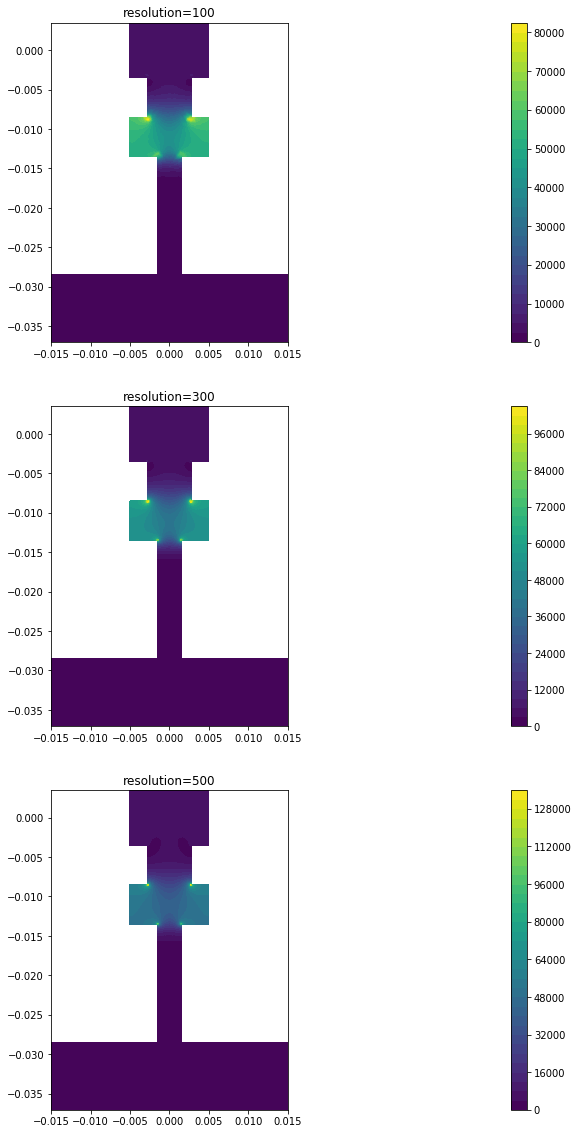

In [8]:
borne_inf_x=-1.5*mesh_dict['L_mot']
borne_sup_x=1.5*mesh_dict['L_mot']
borne_inf_y=-1.3*(.5*mesh_dict['l_mot']+mesh_dict['l_1']+mesh_dict['l_2']+mesh_dict['delta_vert_12'])
borne_sup_y=.5*mesh_dict['l_mot']

plt.figure(figsize=(80,20))

mesh, segments_list, zone = get_mesh(mesh_dict)
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

plt.subplot(3,1,1)
fig=plot(NE)
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.title('resolution=100')

mesh_dict['mesh_resolution']=300
mesh, segments_list, zone = get_mesh(mesh_dict)
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

plt.subplot(3,1,2)
fig=plot(NE)
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.title('resolution=300')

mesh_dict['mesh_resolution']=500
mesh, segments_list, zone = get_mesh(mesh_dict)
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

plt.subplot(3,1,3)
fig=plot(NE)
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.title('resolution=500')

plt.show()

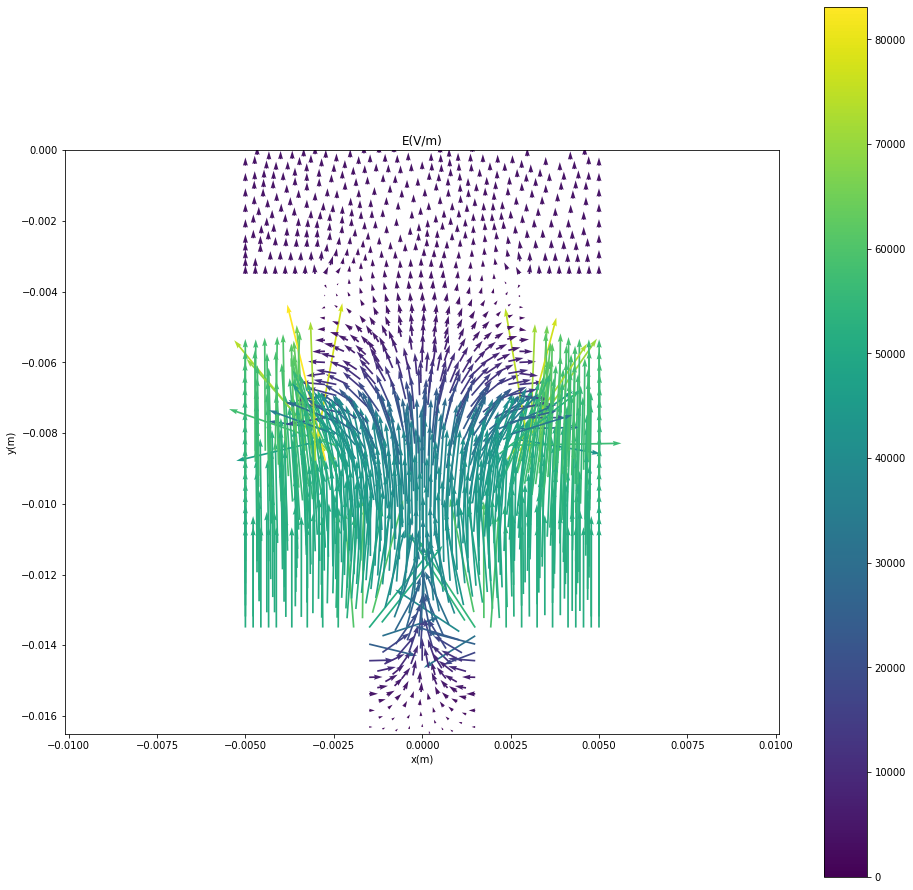

resolution=100


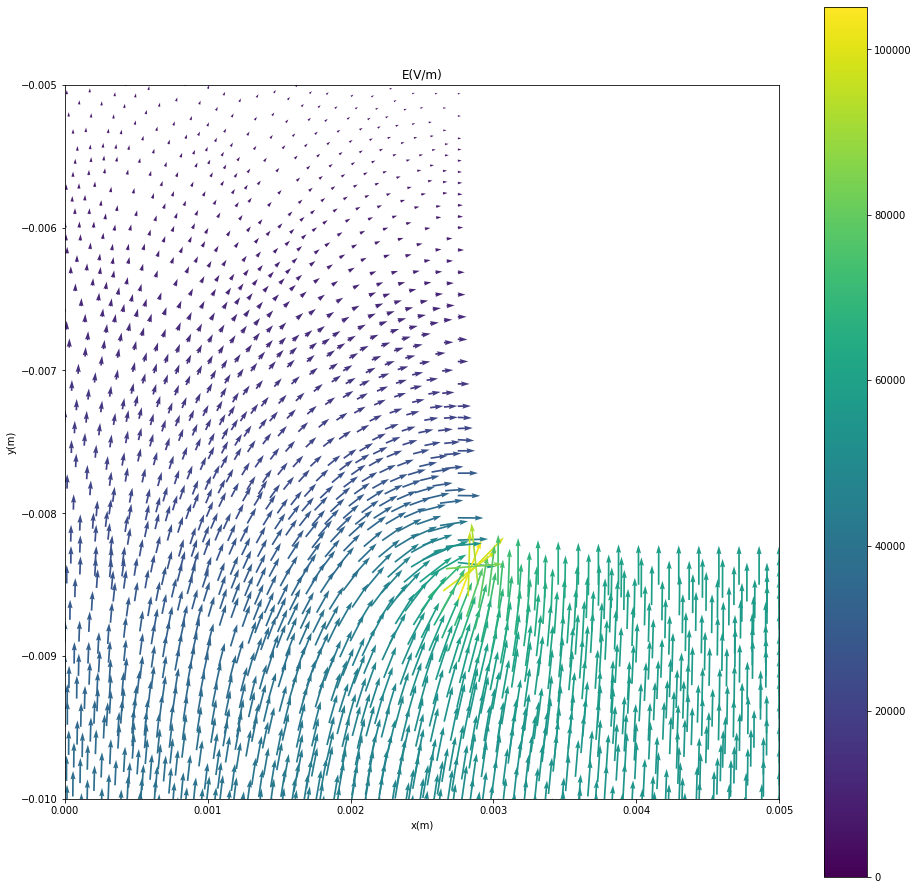

resolution=300


In [9]:
mesh_dict['mesh_resolution']=100
mesh, segments_list, zone = get_mesh(mesh_dict)
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

borne_inf_x=-1.01*mesh_dict['L_mot']
borne_sup_x=1.01*mesh_dict['L_mot']
borne_inf_y=-(.5*mesh_dict['l_mot']+mesh_dict['l_1']+.2*mesh_dict['l_2']+mesh_dict['delta_vert_12'])
borne_sup_y=0

borne_inf_x_bis=0
borne_sup_x_bis=0.005
borne_inf_y_bis=-0.01
borne_sup_y_bis=-.005

plt.figure(figsize=(16,16))
fig=plot(E,mode = "glyphs")
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x,borne_sup_x)
plt.ylim(borne_inf_y,borne_sup_y)
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()
print('resolution=100')

mesh_dict['mesh_resolution']=300
mesh, segments_list, zone = get_mesh(mesh_dict)
Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

plt.figure(figsize=(16,16))
fig=plot(E,mode = "glyphs")
plt.title('E(V/m)')
fig.set_cmap("viridis") 
plt.colorbar(fig)
plt.xlim(borne_inf_x_bis,borne_sup_x_bis)
plt.ylim(borne_inf_y_bis,borne_sup_y_bis)
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()
print('resolution=300')